In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('D:/stat_team/project/beers-breweries-and-beer-reviews/reviews.csv')
df.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score
0,271781,bluejacket74,2017-03-17,"750 ml bottle, 2016 vintage, bottle #304 of...",4.00,4.00,4.00,4.25,4.00,4.03
1,125646,_dirty_,2017-12-21,,4.50,4.50,4.50,4.50,4.50,4.50
2,125646,CJDUBYA,2017-12-21,,4.75,4.75,4.75,4.75,4.75,4.75
3,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally wal...,4.75,4.75,4.50,4.50,4.50,4.58
4,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouq...,4.25,4.50,4.25,4.25,4.25,4.31


In [3]:
#잠깐 전처리

cols = ['beer_id','username','score']
df = df[cols]
df.rename(columns = {'beer_id':'beerid','username':'userid','score':'rating'}, inplace = True)
df.head()

,beerid,userid,rating
0,271781,bluejacket74,4.03
1,125646,_dirty_,4.50
2,125646,CJDUBYA,4.75
3,125646,GratefulBeerGuy,4.58
4,125646,LukeGude,4.31


In [4]:
#딥러닝에 이용할 컬럼 변경: user, beer, rating

user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['userid'].tolist())
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['beer'] = item_enc.fit_transform(df['beerid'].values)
n_beers = df['beer'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

n_users, n_beers, min_rating, max_rating #n_users, n_beers: 유니크한 값 개수, rating의 최솟값과 최댓값.

(164935, 309542, 1.0, 5.0)

In [5]:
df2=df[['user','beer','rating']] 
df2.head() #완료된 데이터셋. 여기서 'user','beer','rating'만 사용

,user,beer,rating
0,102213,231507,4.03
1,94429,112229,4.50
2,15635,112229,4.75
3,34826,112229,4.58
4,55007,112229,4.31


In [6]:
#train, test 셋 분할: test size는 0.2, random_state는 임의로 지정
X = df[['user', 'beer']].values
y = df['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7258502, 2), (1814626, 2), (7258502,), (1814626,))

In [7]:
#딥러닝 모델을 만들 때 필요한 또다른 변수는: 잠재요인의 개수를 정하는 것!
#잠재요인의 개수는 원하는 대로 설정하면 되지만, 주의할 것은 user와 beer 모두에 대해 같은 사이즈를 줘야 한다는 점.

#우리는 50개로 간다!(X에 대해서만 적용)
n_factors = 50

#X를 array로 만들기
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [8]:
#keras 라이브러리 로드
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda, Concatenate

Using TensorFlow backend.


In [9]:
##시각화(각 epoch마다의 MSE, MAE 값 비교)

def plot_history(hist):
    
    plt.figure(figsize=(10,15))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [rating]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Test Error')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$rating^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Test Error')
    plt.legend()
    plt.show()


## ver2. tanh->tanh, test MSE; 0.1868, 과적합

In [14]:
def RecommenderV5_2(n_users, n_beers, n_factors):
    
    #input: user, beer
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user) #u는 user * n_factor
    ub = EmbeddingLayer(n_users, 1)(user) #user_bias
    
    beer = Input(shape=(1,))
    b = EmbeddingLayer(n_beers, n_factors)(beer) #b은 beer * n_factor
    bb = EmbeddingLayer(n_beers, 1)(beer) #beer_bias
    
    #input 연산- activation 2가지를 추가. relu와 sigmoid
    x = Concatenate()([u, b])
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('tanh')(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('tanh')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)


    #최종 모델 만들기(input은 user, beer 2개를 받고, output은 x를 반환.)
    model_2 = Model(inputs=[user, beer], outputs=x)
    opt = Adam(lr=0.01) #learning rate(학습률) 설정. 
    model_2.compile(loss=['mse'], metrics = ['mae','mse'] ,optimizer=opt) 

    return model_2

In [15]:
re5model_2 = RecommenderV5_2(n_users, n_beers, n_factors)
re5model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        8246750     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 50)        15477100    input_4[0][0]                    
____________________________________________________________________________________________

In [16]:
## fit model
import numpy as np
seed = 7
np.random.seed(seed)
history_mf5_2 = re5model_2.fit(x=X_train_array, y=y_train, batch_size=1000, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test)) 

Train on 7258502 samples, validate on 1814626 samples
Epoch 1/10
7258502/7258502 [==============================] - 3938s 543us/step - loss: 0.2064 - mae: 0.3211 - mse: 0.2064 - val_loss: 0.1856 - val_mae: 0.3058 - val_mse: 0.1856
Epoch 2/10
7258502/7258502 [==============================] - 3994s 550us/step - loss: 0.1761 - mae: 0.2968 - mse: 0.1761 - val_loss: 0.1811 - val_mae: 0.2993 - val_mse: 0.1811
Epoch 3/10
7258502/7258502 [==============================] - 4014s 553us/step - loss: 0.1684 - mae: 0.2900 - mse: 0.1684 - val_loss: 0.1798 - val_mae: 0.2989 - val_mse: 0.1798
Epoch 4/10
7258502/7258502 [==============================] - 4544s 626us/step - loss: 0.1567 - mae: 0.2796 - mse: 0.1567 - val_loss: 0.1850 - val_mae: 0.3061 - val_mse: 0.1850
Epoch 7/10
7258502/7258502 [==============================] - 4232s 583us/step - loss: 0.1547 - mae: 0.2778 - mse: 0.1547 - val_loss: 0.1880 - val_mae: 0.3092 - val_mse: 0.1880
Epoch 8/10
7258502/7258502 [==============================] -

In [17]:
## show loss & mae & mse at each epoch
hist5_2 = pd.DataFrame(history_mf5_2.history)
hist5_2['epoch'] = history_mf5_2.epoch

hist5_2

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,0.185551,0.305799,0.185551,0.206444,0.321092,0.206444,0
1,0.181135,0.299251,0.181135,0.176091,0.296786,0.176091,1
2,0.179813,0.298914,0.179813,0.168399,0.290014,0.168399,2
3,0.182008,0.299406,0.182008,0.163200,0.285425,0.163200,3
4,0.182747,0.304076,0.182747,0.159427,0.282101,0.159428,4
5,0.185037,0.306070,0.185037,0.156697,0.279629,0.156697,5
6,0.187984,0.309153,0.187984,0.154691,0.277833,0.154691,6
7,0.186019,0.304118,0.186019,0.153239,0.276434,0.153239,7
8,0.188179,0.307337,0.188179,0.152120,0.275393,0.152121,8
9,0.186777,0.304186,0.186777,0.151281,0.274621,0.151281,9


In [18]:
#모델 평가하기; model.evaluate() #test set에 평가했을 때, 맨 마지막 epoch의 val_loss, val_mae, val_mse
loss_and_metrics_2 = re5model_2.evaluate(X_test_array, y_test, batch_size=1000)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics_2)

1814626/1814626 [==============================] - 4s 2us/step
## evaluation loss and_metrics ##
[0.18677654795995866, 0.3041864037513733, 0.18677657842636108]


In [19]:
## get weights of the beers embedding matrix
beer_embedding_weights_2 = re5model_2.layers[3].get_weights()[0] #3은 beer-embedding : layer 확인!
beer_embedding_weights_2.shape

(309542, 50)

In [20]:
## import PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 3) ## use 3 components
beer_embedding_weights_t_2 = np.transpose(beer_embedding_weights_2) ## pass the transpose of the embedding matrix
beer_pca_2 = pca.fit(beer_embedding_weights_t_2) ## fit

## display the resulting matrix dimensions
beer_pca_2.components_.shape

(3, 309542)

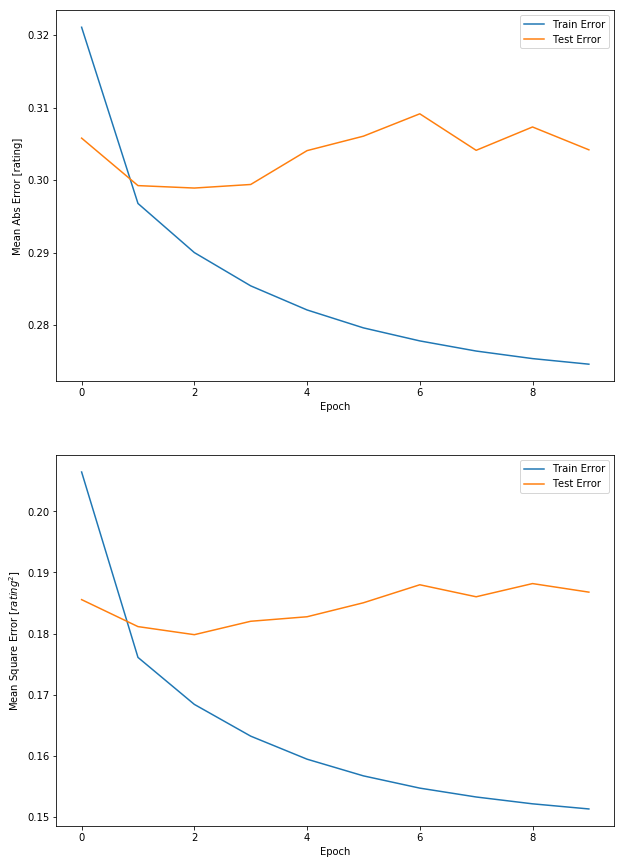

In [21]:
plot_history(hist5_2)